# Importing libraries

In [2]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)
!ls '/content/drive/My Drive/'

Mounted at /content/drive
 CADL-I-FinalPoject			       notes
'Colab Notebooks'			       ottawa-roadnet
 Dog_Cat_Data				       RoadNetDemo
 en_vocab_small.txt			       RoadNetKeras
 fr_vocab_small.txt			       StyleGAN-Tensorflow2-master
 model_94k_faces_glintasia_without_norm.hdf5


In [3]:
import os
import re
import time
import string
import spacy
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

### NLTK dependencies ###
from nltk.corpus import stopwords  
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

### Tensorflow dependencies ###
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Loading and preprocessing data

In [5]:
### 1. Loading data from files and preprocessing ###
def en_contraction_expand(sentence):
    # Dictionary of English Contractions
    contractions_dict = { "ain't": "are not","'s":" is","aren't": "are not",
                     "can't": "cannot","can't've": "cannot have",
                     "'cause": "because","could've": "could have","couldn't": "could not",
                     "couldn't've": "could not have", "didn't": "did not","doesn't": "does not",
                     "don't": "do not","hadn't": "had not","hadn't've": "had not have",
                     "hasn't": "has not","haven't": "have not","he'd": "he would",
                     "he'd've": "he would have","he'll": "he will", "he'll've": "he will have",
                     "how'd": "how did","how'd'y": "how do you","how'll": "how will",
                     "I'd": "I would", "I'd've": "I would have","I'll": "I will",
                     "I'll've": "I will have","I'm": "I am","I've": "I have", "isn't": "is not",
                     "it'd": "it would","it'd've": "it would have","it'll": "it will",
                     "it'll've": "it will have", "let's": "let us","ma'am": "madam",
                     "mayn't": "may not","might've": "might have","mightn't": "might not", 
                     "mightn't've": "might not have","must've": "must have","mustn't": "must not",
                     "mustn't've": "must not have", "needn't": "need not",
                     "needn't've": "need not have","o'clock": "of the clock","oughtn't": "ought not",
                     "oughtn't've": "ought not have","shan't": "shall not","sha'n't": "shall not",
                     "shan't've": "shall not have","she'd": "she would","she'd've": "she would have",
                     "she'll": "she will", "she'll've": "she will have","should've": "should have",
                     "shouldn't": "should not", "shouldn't've": "should not have","so've": "so have",
                     "that'd": "that would","that'd've": "that would have", "there'd": "there would",
                     "there'd've": "there would have", "they'd": "they would",
                     "they'd've": "they would have","they'll": "they will",
                     "they'll've": "they will have", "they're": "they are","they've": "they have",
                     "to've": "to have","wasn't": "was not","we'd": "we would",
                     "we'd've": "we would have","we'll": "we will","we'll've": "we will have",
                     "we're": "we are","we've": "we have", "weren't": "were not","what'll": "what will",
                     "what'll've": "what will have","what're": "what are", "what've": "what have",
                     "when've": "when have","where'd": "where did", "where've": "where have",
                     "who'll": "who will","who'll've": "who will have","who've": "who have",
                     "why've": "why have","will've": "will have","won't": "will not",
                     "won't've": "will not have", "would've": "would have","wouldn't": "would not",
                     "wouldn't've": "would not have","y'all": "you all", "y'all'd": "you all would",
                     "y'all'd've": "you all would have","y'all're": "you all are",
                     "y'all've": "you all have", "you'd": "you would","you'd've": "you would have",
                     "you'll": "you will","you'll've": "you will have", "you're": "you are",
                     "you've": "you have"}

    contractions_re=re.compile('(%s)' % '|'.join(contractions_dict.keys()))
    def replace(match):
        return contractions_dict[match.group(0)]
    
    return contractions_re.sub(replace, sentence)

def filter_stopwords(text, lang='en'):
    ### Stopword removal using the nltk way ###
    if(lang == 'en') : 
        language = 'english'
    elif(lang == 'fr'):
        language = 'french'
        
    stop_words = set(stopwords.words(language)) # Assuming all nltk data is installed
    lemmatizer = WordNetLemmatizer()
    
    word_tokens = word_tokenize(text)
    filtered = [lemmatizer.lemmatize(w) for w in word_tokens if not w in stop_words]
    
    filtered_sentence = ' '.join(filtered)
    return filtered_sentence

def preprocess_sentence(sentence, lang='en'):
    # 1. expand contraction for english
    if(lang == 'en'):
        sentence = en_contraction_expand(sentence)
    
    # 2. lowercasing text
    sentence = sentence.strip().lower()
    
    # 3. Digits removal
    sentence = re.sub('\w*\d\w*','', sentence)

    # 4. Punctuations removal
    sentence = re.sub('[%s]' % re.escape(string.punctuation), '', sentence)
    
    # 5. Extra spaces removal
    sentence = re.sub(' +',' ', sentence)
    
    # 5. filter stopwords 
    # sentence = filter_stopwords(sentence, lang=lang)
    
    return sentence
    
def load_data(filename, lang="en"):
    start = time.time()
    lines = open(filename, 'r').readlines()
    
    if(lang == "en"):
        lines = [preprocess_sentence(x, lang=lang) for x in lines]
    elif(lang == "fr"):
        lines = [preprocess_sentence(x, lang=lang) for x in lines]
        
    lines = np.array(lines)
    end = time.time()
    
    print(f'[INFO] Took {end - start} seconds to load {filename}')
    return lines

data_en = load_data("/content/drive/My Drive/en_vocab_small.txt")
data_fr = load_data("/content/drive/My Drive/fr_vocab_small.txt", lang="fr")

[INFO] Took 5.898597717285156 seconds to load /content/drive/My Drive/en_vocab_small.txt
[INFO] Took 3.0017664432525635 seconds to load /content/drive/My Drive/fr_vocab_small.txt


In [6]:
### 2. Vectorize text data for model training ###
print('[INFO] Tokenizing english data ...')
en_tokenizer = Tokenizer(char_level=False, oov_token="PAD") # 0 is a reserved index
en_tokenizer.fit_on_texts(data_en)
data_en_seq = en_tokenizer.texts_to_sequences(data_en)

print('[INFO] Tokenizing french data ...')
fr_tokenizer = Tokenizer(char_level=False, oov_token="PAD")
fr_tokenizer.fit_on_texts(data_fr)
data_fr_seq = fr_tokenizer.texts_to_sequences(data_fr)

print(data_en_seq[0])

[INFO] Tokenizing english data ...
[INFO] Tokenizing french data ...
[18, 24, 2, 9, 68, 5, 40, 8, 4, 2, 56, 3, 45]


In [7]:
### Sequence padding ###
def pad(x, length=None):
    if length is None:
        length = max([len(sentence) for sentence in x])
    return pad_sequences(x, maxlen = length, padding = 'post')

print('[INFO] Padding sequence for french data ...')
data_fr_seq = pad(data_fr_seq)

print('[INFO] Padding sequence for english data ...')
data_en_seq = pad(data_en_seq, length=data_fr_seq.shape[-1])

fr_vocab_size = np.max(data_fr_seq) + 1
en_vocab_size = np.max(data_en_seq) + 1
print('----------------------------------------------')
print(f'[INFO] Max english sentence length : {data_en_seq.shape[-1]}')
print(f'[INFO] Max french sentence length : {data_fr_seq.shape[-1]}')
print(f'[INFO] French vocab size : {fr_vocab_size}')
print(f'[INFO] English vocab size : {en_vocab_size}')

[INFO] Padding sequence for french data ...
[INFO] Padding sequence for english data ...
----------------------------------------------
[INFO] Max english sentence length : 21
[INFO] Max french sentence length : 21
[INFO] French vocab size : 346
[INFO] English vocab size : 198


In [8]:
### Test inverse transform from index to words ###
print(en_tokenizer.sequences_to_texts([data_en_seq[0]]))
print(data_en_seq[0])

['new jersey is sometimes quiet during autumn and it is snowy in april PAD PAD PAD PAD PAD PAD PAD PAD']
[18 24  2  9 68  5 40  8  4  2 56  3 45  0  0  0  0  0  0  0  0]


# Building model

## 1. Basic RNN model

In [10]:
data_en_seq = data_en_seq.reshape(-1, data_en_seq.shape[1], 1)
def make_rnn_model(input_shape, output_length, fr_vocab_size):
    inputs = Input(shape=input_shape[1:])
    rnn = GRU(64, return_sequences = True)(inputs)
    
    # same size as the vocab so we have one hot vector of all words
    logits = TimeDistributed(Dense(fr_vocab_size))(rnn)
    output = Activation('softmax')(logits)
    model = Model(inputs=inputs, outputs=output, name='Basic_RNN')
    model.compile(optimizer='adam',
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])
    
    return model

model = make_rnn_model(data_en_seq.shape, data_fr_seq.shape[-1], fr_vocab_size)
print(model.summary())

Model: "Basic_RNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 21, 1)]           0         
_________________________________________________________________
gru_1 (GRU)                  (None, 21, 64)            12864     
_________________________________________________________________
time_distributed (TimeDistri (None, 21, 346)           22490     
_________________________________________________________________
activation (Activation)      (None, 21, 346)           0         
Total params: 35,354
Trainable params: 35,354
Non-trainable params: 0
_________________________________________________________________
None


In [18]:
history = model.fit(data_en_seq, data_fr_seq, batch_size=1024, epochs=20, validation_split=0.2)

Epoch 1/20
108/108 [==============================] - 3s 15ms/step - loss: 4.3951 - accuracy: 0.3670 - val_loss: 2.5496 - val_accuracy: 0.4721
Epoch 2/20
108/108 [==============================] - 1s 11ms/step - loss: 2.4991 - accuracy: 0.4729 - val_loss: 2.3253 - val_accuracy: 0.4926
Epoch 3/20
108/108 [==============================] - 1s 11ms/step - loss: 2.2665 - accuracy: 0.4951 - val_loss: 2.0921 - val_accuracy: 0.5207
Epoch 4/20
108/108 [==============================] - 1s 11ms/step - loss: 2.0357 - accuracy: 0.5332 - val_loss: 1.8840 - val_accuracy: 0.5583
Epoch 5/20
108/108 [==============================] - 1s 11ms/step - loss: 1.8547 - accuracy: 0.5608 - val_loss: 1.7670 - val_accuracy: 0.5666
Epoch 6/20
108/108 [==============================] - 1s 11ms/step - loss: 1.7488 - accuracy: 0.5665 - val_loss: 1.6884 - val_accuracy: 0.5697
Epoch 7/20
108/108 [==============================] - 1s 11ms/step - loss: 1.6718 - accuracy: 0.5695 - val_loss: 1.6248 - val_accuracy: 0.5735

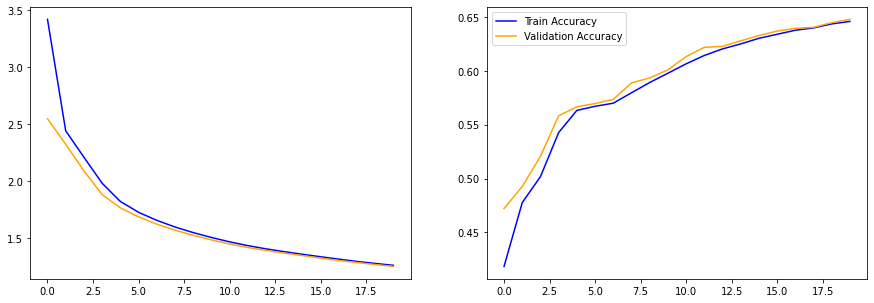

In [19]:
train_loss = model.history.history['loss']
val_loss = model.history.history['val_loss']

train_acc = model.history.history['accuracy']
val_acc = model.history.history['val_accuracy']

fig, ax = plt.subplots(1,2, figsize=(15, 5))

ax[0].plot(train_loss, label='Train Loss', color='blue')
ax[0].plot(val_loss, label='Validation Loss', color='orange')

ax[1].plot(train_acc, label='Train Accuracy', color='blue')
ax[1].plot(val_acc, label='Validation Accuracy', color='orange')
plt.legend()
plt.show()

In [20]:
### Testing predictions ###
predictions = model.predict(data_en_seq[0:200])
print(np.argmax(predictions, axis=-1)[0])

[35 34  2  9  9  3 12  7  4  2  2  3  3  0  0  0  0  0  0  0  0]


In [21]:
predicted_text = fr_tokenizer.sequences_to_texts([np.argmax(predictions, axis=-1)[0]])[0]
predicted_text = predicted_text.replace("PAD", "").strip()
print(predicted_text)

['new jersey est parfois parfois en l et il est est en en PAD PAD PAD PAD PAD PAD PAD PAD']

## 2. Basic RNN + Word embedding

In [22]:
def make_rnn_with_embedding(input_shape, fr_vocab_size):
  # Embedding layer can only be used as the first layer
  inputs = Input(shape=input_shape[1:])
  embs   = Embedding(fr_vocab_size, 64, input_length=input_shape[1])(inputs)
  embs   = Reshape(target_shape=(input_shape[1], 64))(embs)

  rnn = GRU(64, return_sequences = True)(embs)
    
  # same size as the vocab so we have one hot vector of all words
  logits = TimeDistributed(Dense(fr_vocab_size))(rnn)
  output = Activation('softmax')(logits)
  model = Model(inputs=inputs, outputs=output, name='Basic_RNN')
  model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
    
  return model

model = make_rnn_with_embedding(data_en_seq.shape, fr_vocab_size)
print(model.summary())

Model: "Basic_RNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 21, 1)]           0         
_________________________________________________________________
embedding (Embedding)        (None, 21, 1, 64)         22144     
_________________________________________________________________
reshape (Reshape)            (None, 21, 64)            0         
_________________________________________________________________
gru_2 (GRU)                  (None, 21, 64)            24960     
_________________________________________________________________
time_distributed_2 (TimeDist (None, 21, 346)           22490     
_________________________________________________________________
activation_2 (Activation)    (None, 21, 346)           0         
Total params: 69,594
Trainable params: 69,594
Non-trainable params: 0
_____________________________________________________

In [23]:
history = model.fit(data_en_seq, data_fr_seq, batch_size=1024, epochs=20, validation_split=0.2)

Epoch 1/20
108/108 [==============================] - 3s 19ms/step - loss: 4.6424 - accuracy: 0.3779 - val_loss: 2.9659 - val_accuracy: 0.4130
Epoch 2/20
108/108 [==============================] - 2s 14ms/step - loss: 2.8340 - accuracy: 0.4298 - val_loss: 2.3648 - val_accuracy: 0.5162
Epoch 3/20
108/108 [==============================] - 2s 14ms/step - loss: 2.2018 - accuracy: 0.5319 - val_loss: 1.7569 - val_accuracy: 0.6005
Epoch 4/20
108/108 [==============================] - 2s 14ms/step - loss: 1.6505 - accuracy: 0.6098 - val_loss: 1.3668 - val_accuracy: 0.6606
Epoch 5/20
108/108 [==============================] - 2s 14ms/step - loss: 1.3008 - accuracy: 0.6800 - val_loss: 1.1196 - val_accuracy: 0.7244
Epoch 6/20
108/108 [==============================] - 2s 14ms/step - loss: 1.0750 - accuracy: 0.7338 - val_loss: 0.9567 - val_accuracy: 0.7575
Epoch 7/20
108/108 [==============================] - 2s 14ms/step - loss: 0.9269 - accuracy: 0.7631 - val_loss: 0.8381 - val_accuracy: 0.7810

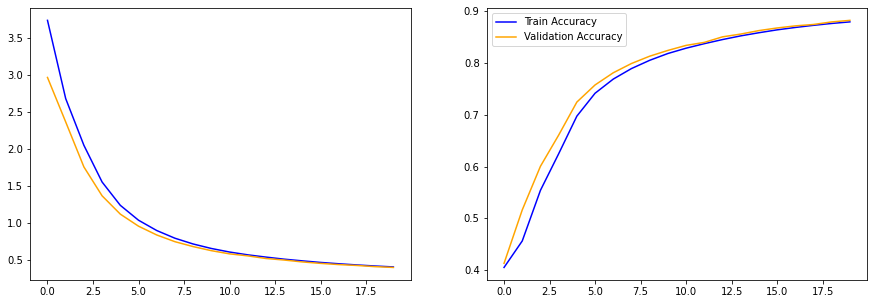

In [24]:
train_loss = model.history.history['loss']
val_loss = model.history.history['val_loss']

train_acc = model.history.history['accuracy']
val_acc = model.history.history['val_accuracy']

fig, ax = plt.subplots(1,2, figsize=(15, 5))

ax[0].plot(train_loss, label='Train Loss', color='blue')
ax[0].plot(val_loss, label='Validation Loss', color='orange')

ax[1].plot(train_acc, label='Train Accuracy', color='blue')
ax[1].plot(val_acc, label='Validation Accuracy', color='orange')
plt.legend()
plt.show()

In [25]:
### Testing predictions ###
predictions = model.predict(data_en_seq[0:200])
print(np.argmax(predictions, axis=-1)[0])

[ 35  34   2   9  67   3  12   7   4   2 112 112   3  50   0   0   0   0
   0   0   0]


In [27]:
predicted_text = fr_tokenizer.sequences_to_texts([np.argmax(predictions, axis=-1)[0]])[0]
predicted_text = predicted_text.replace("PAD", "").strip()
print(predicted_text)

new jersey est parfois calme en l et il est neigeux neigeux en avril


## 3. Bidirectional RNN

In [22]:
 def make_bidirectional_rnn(input_shape, fr_vocab_size):
  # Embedding layer can only be used as the first layer
  inputs = Input(shape=input_shape[1:])
  embs   = Embedding(fr_vocab_size, 128, input_length=input_shape[1])(inputs)
  embs   = Reshape(target_shape=(input_shape[1], 128))(embs)

  rnn = Bidirectional(LSTM(64, return_sequences = True))(embs) # better without dropout
    
  # same size as the vocab so we have one hot vector of all words
  logits = TimeDistributed(Dense(fr_vocab_size))(rnn)
  output = Activation('softmax')(logits)
  model = Model(inputs=inputs, outputs=output, name='Basic_RNN')
  model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
    
  return model

model = make_bidirectional_rnn(data_en_seq.shape, fr_vocab_size)
print(model.summary())

Model: "Basic_RNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 21, 1)]           0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 21, 1, 128)        44288     
_________________________________________________________________
reshape (Reshape)            (None, 21, 128)           0         
_________________________________________________________________
bidirectional_4 (Bidirection (None, 21, 128)           98816     
_________________________________________________________________
time_distributed_4 (TimeDist (None, 21, 346)           44634     
_________________________________________________________________
activation_4 (Activation)    (None, 21, 346)           0         
Total params: 187,738
Trainable params: 187,738
Non-trainable params: 0
___________________________________________________

In [23]:
history = model.fit(data_en_seq, data_fr_seq, batch_size=1024, epochs=20, validation_split=0.2)

Epoch 1/20
108/108 [==============================] - 6s 29ms/step - loss: 4.2799 - accuracy: 0.3898 - val_loss: 2.4614 - val_accuracy: 0.4964
Epoch 2/20
108/108 [==============================] - 2s 22ms/step - loss: 2.3195 - accuracy: 0.5032 - val_loss: 1.9376 - val_accuracy: 0.5424
Epoch 3/20
108/108 [==============================] - 2s 22ms/step - loss: 1.8222 - accuracy: 0.5613 - val_loss: 1.4952 - val_accuracy: 0.6237
Epoch 4/20
108/108 [==============================] - 2s 22ms/step - loss: 1.4046 - accuracy: 0.6429 - val_loss: 1.1544 - val_accuracy: 0.7047
Epoch 5/20
108/108 [==============================] - 2s 22ms/step - loss: 1.0921 - accuracy: 0.7202 - val_loss: 0.9212 - val_accuracy: 0.7570
Epoch 6/20
108/108 [==============================] - 2s 23ms/step - loss: 0.8833 - accuracy: 0.7638 - val_loss: 0.7827 - val_accuracy: 0.7826
Epoch 7/20
108/108 [==============================] - 2s 22ms/step - loss: 0.7571 - accuracy: 0.7890 - val_loss: 0.6838 - val_accuracy: 0.8073

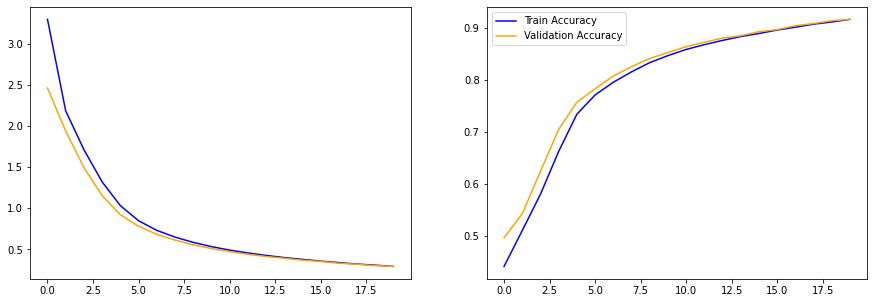

In [24]:
train_loss = model.history.history['loss']
val_loss = model.history.history['val_loss']

train_acc = model.history.history['accuracy']
val_acc = model.history.history['val_accuracy']

fig, ax = plt.subplots(1,2, figsize=(15, 5))

ax[0].plot(train_loss, label='Train Loss', color='blue')
ax[0].plot(val_loss, label='Validation Loss', color='orange')

ax[1].plot(train_acc, label='Train Accuracy', color='blue')
ax[1].plot(val_acc, label='Validation Accuracy', color='orange')
plt.legend()
plt.show()

In [25]:
### Testing predictions ###
predictions = model.predict(data_en_seq[0:200])
print(np.argmax(predictions, axis=-1)[0])

[ 35  34   2   9  67  16 111   7   4   4   2   3   3  50   0   0   0   0
   0   0   0]


In [26]:
predicted_text = fr_tokenizer.sequences_to_texts([np.argmax(predictions, axis=-1)[0]])[0]
predicted_text = predicted_text.replace("PAD", "").strip()
print(predicted_text)

new jersey est parfois calme au cours et il il est en en avril


## 4. Encoder-Decoder architecture